In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import cv2
import numpy as np
from tensorflow import keras

In [20]:
image_dir = '../data/train/matching_images/'
image_size = (128, 128)  # Specify the desired image size

# Get the list of image file names in the directory
image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.jpg')]

# Initialize empty lists to store the images and labels
images = []
labels = []

# Read and preprocess each image
for file in image_files:
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert color channels from BGR to RGB
    image = cv2.resize(image, image_size)  # Resize the image to the desired size
    image = image / 255.0  # Normalize the pixel values to the range [0, 1]
    images.append(image)
    
    # Extract the label from the first letter of the file name
    label = file.split('/')[-1][0]
    labels.append(label)

# Convert the lists to NumPy arrays
x_train = np.array(images)
y_train = np.array(labels)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)


x_train shape: (504, 128, 128, 3)
y_train shape: (504,)


In [21]:
image_dir = '../data/test/matching_images/'
image_size = (128, 128)  # Specify the desired image size

# Get the list of image file names in the directory
image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.jpg')]

# Initialize empty lists to store the images and labels
images = []
labels = []

# Read and preprocess each image
for file in image_files:
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert color channels from BGR to RGB
    image = cv2.resize(image, image_size)  # Resize the image to the desired size
    image = image / 255.0  # Normalize the pixel values to the range [0, 1]
    images.append(image)
    
    # Extract the label from the first letter of the file name
    label = file.split('/')[-1][0]
    labels.append(label)

# Convert the lists to NumPy arrays
x_test = np.array(images)
y_test = np.array(labels)

print("x_test shape:", x_train.shape)
print("y_test shape:", y_train.shape)


x_test shape: (504, 128, 128, 3)
y_test shape: (504,)


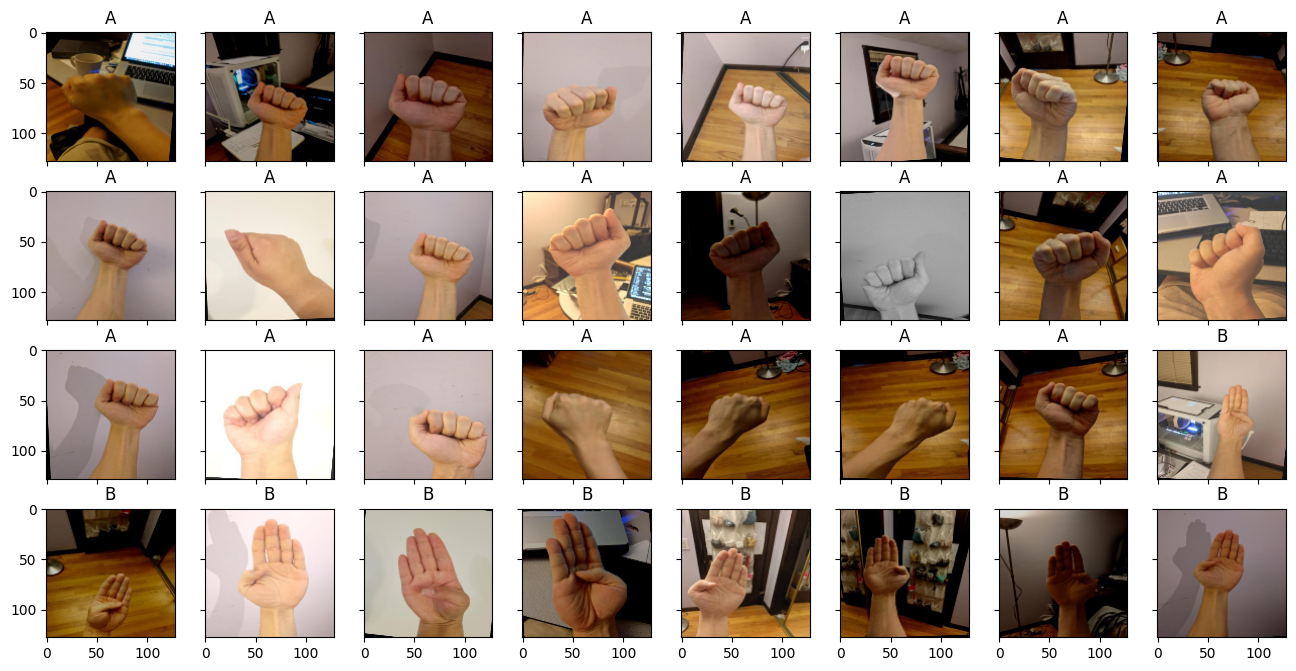

In [44]:
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

In [62]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(128, 128), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size
      self.y = y
      self.X = X
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle == True:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
    
    for i, idx in enumerate(idxs):
        tmp_image = self.X[idx].copy()
        
        x = np.random.randint(0, self.dim[1] - 40)  # Random x-coordinate for the top-left corner of the black box
        y = np.random.randint(0, self.dim[0] - 40)  # Random y-coordinate for the top-left corner of the black box
        w = np.random.randint(10, 41)  # Random width of the black box (between 10 and 40)
        h = np.random.randint(10, 41)  # Random height of the black box (between 10 and 40)

        tmp_image[y:y+h, x:x+w] = 0  # Apply the black box to the image

        X_batch[i, ] = tmp_image
        y_batch[i] = self.y[idx]
        
    return X_batch, y_batch


In [63]:
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test)

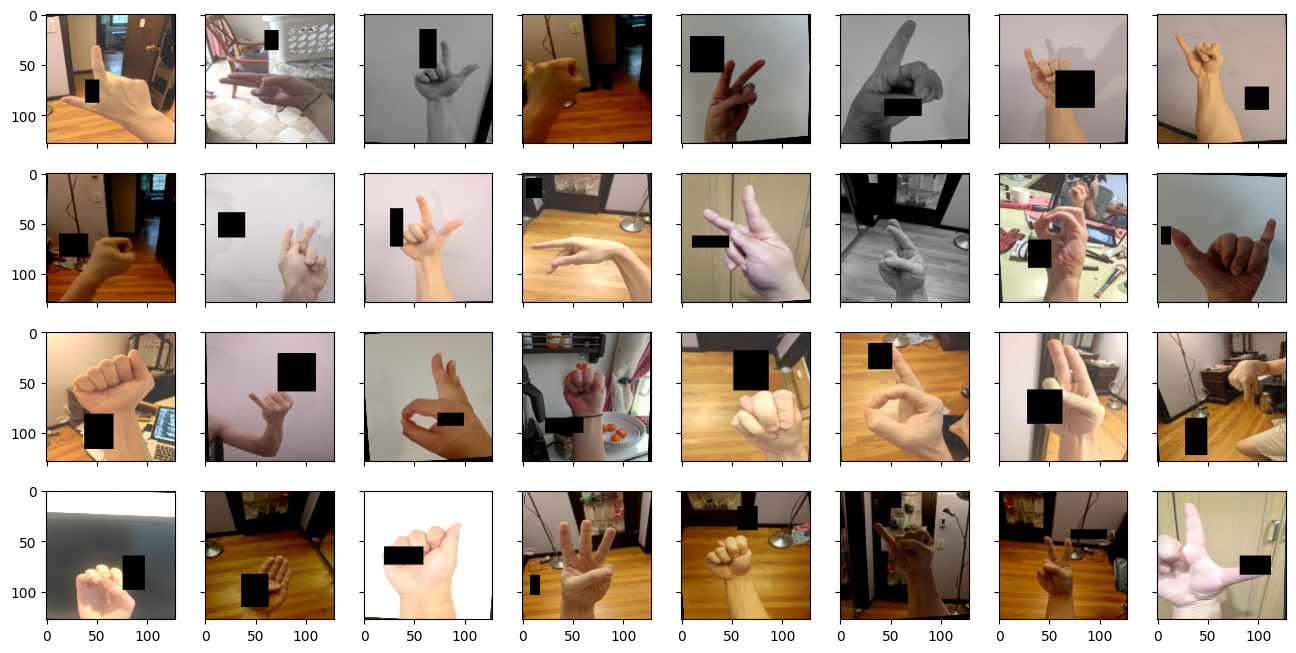

In [64]:
## Examples
sample_idx = 0 ## Change this to see different batches

sample_images, sample_labels = traingen[sample_idx]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

In [66]:
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + 1)

In [67]:
def unet_like():
  inputs = keras.layers.Input((32, 32, 3))
  conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
  pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
  pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
  conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

  up6 = keras.layers.concatenate([keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
  conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
  conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
  up7 = keras.layers.concatenate([keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
  conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
  conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
  up8 = keras.layers.concatenate([keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
  conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
  conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
  up9 = keras.layers.concatenate([keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
  conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
  conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
  conv10 = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

  return keras.models.Model(inputs=[inputs], outputs=[conv10])  

In [68]:
keras.backend.clear_session()
model = unet_like()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

In [69]:
model.fit(traingen, validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True)

Epoch 1/20
